In [54]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
# csv link: https://docs.google.com/spreadsheets/d/12IU6IvKchtKJ3nBvwDcS_5HqmC8G6KxW18HGRIfDPjI/edit?usp=sharing

In [ ]:
df = pd.read_csv('Series - Sheet1.csv') # put download name here
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
# game_order = ['8 Ball', 'Archery', 'Darts', 'Cup Pong', 'Mini Golf', 'Knockout', 'Shuffleboard', '9 Ball', 'Tanks']
bargroup = (df.groupby(['Game', 'Result']).count()).astype(int)
# bargroup = bargroup.reindex(game_order, level='Game')
pointgroup = (df.groupby(['Date', 'Result']).count()).astype(int)
all_dates = df['Date'].unique()
all_results = df['Result'].unique()
multi_index = pd.MultiIndex.from_product([all_dates, all_results], names=['Date', 'Result'])
pointgroup = pointgroup.reindex(multi_index, fill_value=0)
pointgroup = pointgroup.reindex(df['Date'].unique(), level='Date')

# Ensure all unique values for result are present for each game in bargroup even if the value is 0
all_games = df['Game'].unique()
multi_index_bargroup = pd.MultiIndex.from_product([all_games, all_results], names=['Game', 'Result'])
bargroup = bargroup.reindex(multi_index_bargroup, fill_value=0)

bargroup['Win Ratio (Aidan/Oliver)'] = bargroup.apply(lambda row: row['Date'] / bargroup.loc[(row.name[0], 'Oliver Win'), 'Date'] if row.name[1] == 'Aidan Win' else (bargroup.loc[(row.name[0], 'Aidan Win'), 'Date'] / row['Date'] if row.name[1] == 'Oliver Win' else 0), axis=1)

bargroup = bargroup.sort_values(by='Win Ratio (Aidan/Oliver)', ascending=False)
pointgroupnodraw = pointgroup[pointgroup.index.get_level_values('Result') != 'Draw']

In [56]:
games = df['Game'].unique()
win_percentages = []

for g in games:
    game_df = df[(df['Game'] == g) & (df['Result'] != 'Draw')]
    sender_wins = game_df[game_df['Sender'] == game_df['Result'].str.split().str[0]].shape[0]
    total_games = game_df.shape[0]
    sender_win_percentage = (sender_wins / total_games) * 100 if total_games > 0 else 0
    win_percentages.append((g, sender_win_percentage))

win_percentages.sort(key=lambda x: x[1], reverse=True)
print('Sender Win Percentages:')
for g, sender_win_percentage in win_percentages:
    print(f'{g}: {sender_win_percentage:.2f}%')


Sender Win Percentages:
Archery: 73.08%
8 Ball: 61.43%
Mini Golf: 55.00%
Darts: 54.24%
Knockout: 53.57%
Shuffleboard: 45.59%
9 Ball: 42.86%
Cup Pong: 35.71%
Tanks: 18.18%


    Aidan Game Wins  Oliver Game Wins  Frequency Series Winner  \
1                 4                 3          9         Aidan   
2                 3                 4          9        Oliver   
3                 3                 5          8        Oliver   
4                 2                 5          6        Oliver   
5                 5                 3          5         Aidan   
6                 5                 4          5         Aidan   
7                 4                 5          5        Oliver   
8                 2                 6          5        Oliver   
9                 2                 4          4        Oliver   
10                1                 6          4        Oliver   
11                2                 3          3        Oliver   
12                1                 5          2        Oliver   
13                5                 2          1         Aidan   
14                4                 2          1         Aidan   
15        

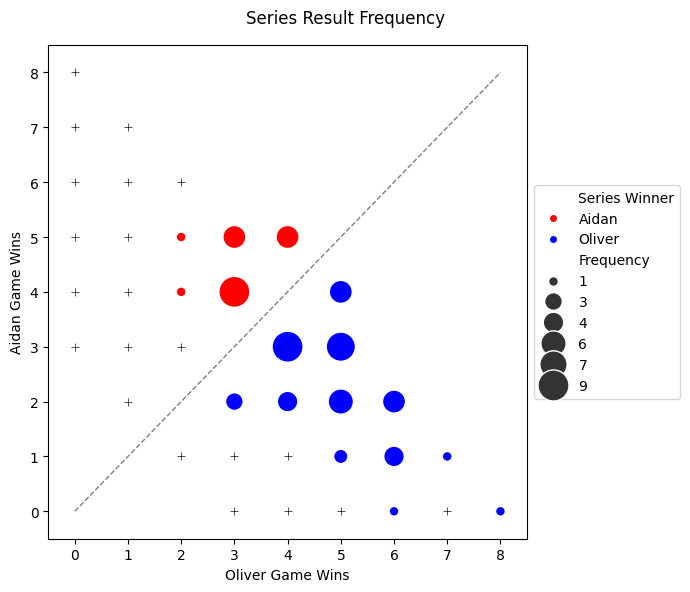

In [57]:
results = df['Result'].unique()
resultaidan = []
resultoliver = []

for d in df['Date'].unique():
    x = df[df['Date'] == d]
    for i, y in enumerate(results):
        if y not in x['Result'].unique():
            if y == 'Aidan Win':
                resultaidan.append(0)
            elif y == 'Oliver Win':
                resultoliver.append(0)
        else:
            if y == 'Aidan Win':
                resultaidan.append(len(x[x['Result'] == y]))
            elif y == 'Oliver Win':
                resultoliver.append(len(x[x['Result'] == y]))
resultbyplayer = pd.DataFrame({'Aidan Game Wins': resultaidan, 'Oliver Game Wins': resultoliver})

resultbyplayer['Winner Margin'] = resultbyplayer['Aidan Game Wins'] - resultbyplayer['Oliver Game Wins']
resultbyplayer['Series Winner'] = resultbyplayer.apply(lambda row: 'Aidan' if row['Winner Margin'] > 0 else ('Oliver' if row['Winner Margin'] < 0 else 'Draw'), axis=1)
resultbyplayer['Frequency'] = resultbyplayer.groupby(['Aidan Game Wins', 'Oliver Game Wins'])['Series Winner'].transform('count')

# print(resultbyplayer)

unique_combinations = resultbyplayer.groupby(['Aidan Game Wins', 'Oliver Game Wins']).size().reset_index(name='Frequency')

unique_combinations['Series Winner'] = unique_combinations.apply(lambda row: 'Aidan' if row['Aidan Game Wins'] > row['Oliver Game Wins'] else ('Oliver' if row['Aidan Game Wins'] < row['Oliver Game Wins'] else 'Draw'), axis=1)

unique_combinations['Winner Game Wins'] = unique_combinations.apply(lambda row: row['Aidan Game Wins'] if row['Series Winner'] == 'Aidan' else (row['Oliver Game Wins'] if row['Series Winner'] == 'Oliver' else 0), axis=1)
unique_combinations['Loser Game Wins'] = unique_combinations.apply(lambda row: row['Oliver Game Wins'] if row['Series Winner'] == 'Aidan' else (row['Aidan Game Wins'] if row['Series Winner'] == 'Oliver' else 0), axis=1)

unique_combinations['Aidan-Oliver Result'] = unique_combinations['Aidan Game Wins'].astype(str) + '-' + unique_combinations['Oliver Game Wins'].astype(str)
unique_combinations['Score Sum'] = unique_combinations['Aidan Game Wins'] + unique_combinations['Oliver Game Wins']
unique_combinations['Margin'] = unique_combinations['Aidan Game Wins'] - unique_combinations['Oliver Game Wins']
unique_combinations['Margin*Score Sum'] = unique_combinations['Margin'] * unique_combinations['Score Sum']
unique_combinations['Abs Score'] = unique_combinations.apply(
    lambda row: row['Aidan-Oliver Result'][::-1] if row['Margin'] < 0 else row['Aidan-Oliver Result'], axis=1
)
unique_combinations = unique_combinations.sort_values(by=['Frequency', 'Margin', 'Score Sum'], ascending=[False, False, True])
unique_combinations.reset_index(drop=True, inplace=True)
# unique_combinations = unique_combinations.drop(['Aidan Game Wins', 'Oliver Game Wins'], axis=1)
# unique_combinations = unique_combinations.iloc[:, [1, 2, 3, 4, 0, 5]]
unique_combinations.index += 1
print(unique_combinations)

fig, ax = plt.subplots(figsize=(7, 6))

x_marks = [i for i in range(9)] * 9
y_marks = (pd.Series(x_marks[:9])).repeat(9)
d_marks = pd.DataFrame({'x': x_marks, 'y': y_marks})
d_marks = d_marks[d_marks['x'] != d_marks['y']]
d_marks.reset_index(drop=True, inplace=True)

deleteindex = []
deletepairs = [[8, 0], [7, 1], [6, 2], [5, 4]]

# comment the block below to show all ticks
d_marks_possible = d_marks[d_marks['x'] + d_marks['y'] > 2]
for d in d_marks.index:
    for p in deletepairs:
        for i, x in enumerate([['x', 'y'], ['y', 'x']]):
            if d_marks[x[0]][d] == p[0] and d_marks[x[1]][d] > p[1]:
                deleteindex.append(d)
d_marks_possible = d_marks_possible.drop(deleteindex)


# p_marks shows all possible marks except x=y
# p_marks = sns.scatterplot(data=d_marks, x='x', y='y', marker='+', color='gray', alpha=.25, legend=False, ax=ax)
p_marks_possible = sns.scatterplot(data=d_marks_possible, x='x', y='y', marker='+', color='k', legend=False, ax=ax)

g = sns.scatterplot(
    data=resultbyplayer, 
    y='Aidan Game Wins', 
    x='Oliver Game Wins', 
    hue='Series Winner', 
    hue_order=['Aidan', 'Oliver'], 
    palette=['red', 'blue'], 
    size='Frequency', 
    legend=True,
    sizes=(50, 500),
    ax=ax
)
fig.suptitle('Series Result Frequency')
g.plot([0, 8], [0, 8], color='k', linestyle='--', linewidth=1, alpha=0.5)
g.set_xlim(-.5, 8.5)
g.set_ylim(-.5, 8.5)
g.set_xlabel('Oliver Game Wins')
g.set_ylabel('Aidan Game Wins')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig('3Result Frequency.png', dpi=600)


Text(0.5, 1.0, 'Series Result Frequency')

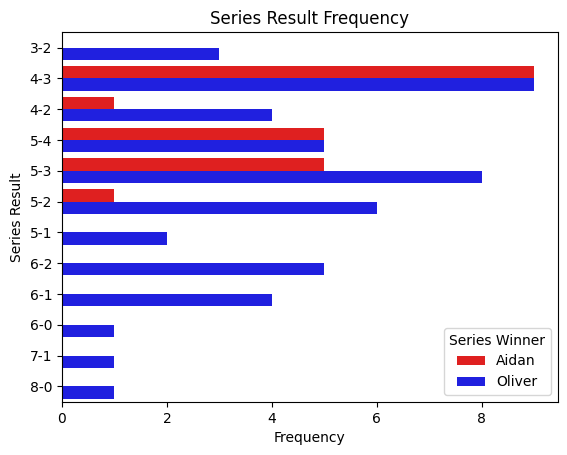

In [58]:
unique_combinations = unique_combinations.sort_values(by=['Winner Game Wins', 'Loser Game Wins'], ascending=[True, False])

g = sns.barplot(data=unique_combinations, x='Frequency', y='Abs Score', hue='Series Winner', hue_order=['Aidan', 'Oliver'], palette=['red', 'blue'])
g.set_ylabel('Series Result')
g.set_title('Series Result Frequency')


Series sent by Aidan:
    Aidan 13–27 Oliver
Series sent by Oliver:
    Aidan 8–22 Oliver
Total Series Wins:
    Aidan 21–49 Oliver
Total Game Wins:
    Aidan 209–307 Oliver (55 Draws)


/var/folders/3n/fh7zd3gd0b3dp6dcp0tn416h0000gn/T/ipykernel_2375/2287226988.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), rotation=90)


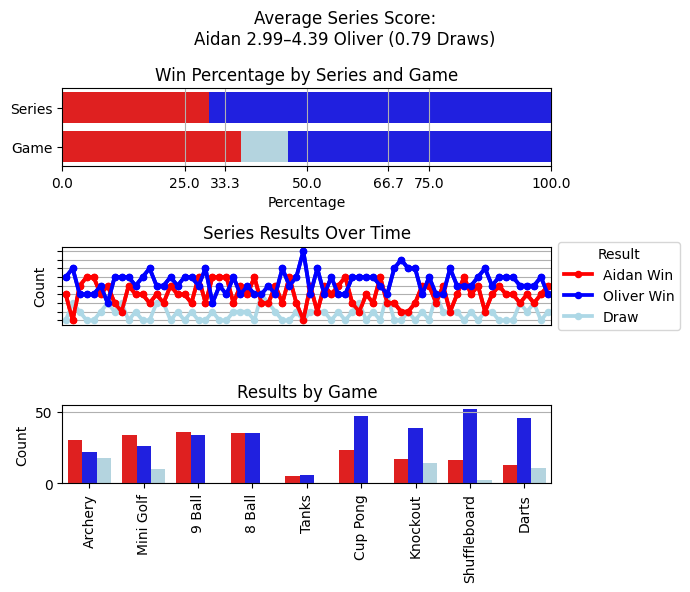

In [59]:
# Calculate the number of series won per player
aidan_wins = []
oliver_wins = []
winner = []
sender = []
aidan_winsbyseries = []
oliver_winsbyseries = []
drawsbyseries = []

for d in df['Date'].unique():
    series_df = df[df['Date'] == d]
    aidan_winsbyseries.append(len(series_df[series_df['Result'] == 'Aidan Win']))
    oliver_winsbyseries.append(len(series_df[series_df['Result'] == 'Oliver Win']))
    if len(series_df[series_df['Result'] == 'Aidan Win']) > len(series_df[series_df['Result'] == 'Oliver Win']):
        winner.append('Aidan')
    else:
        winner.append('Oliver')
    drawsbyseries.append(len(series_df[series_df['Result'] == 'Draw']))
    if 'Aidan' in series_df['Sender'].unique():
        sender.append('Aidan')
    else:
        sender.append('Oliver')
    a_wins = series_df[series_df['Result'] == 'Aidan Win'].shape[0]
    o_wins = series_df[series_df['Result'] == 'Oliver Win'].shape[0]
    if a_wins > o_wins:
        aidan_wins.append('win')
    else:
        oliver_wins.append('win')

sends_df = pd.DataFrame({'Sender': sender, 'Winner': winner})

title = f'Average Series Score:\nAidan {(np.mean(aidan_winsbyseries)):.2f}–{(np.mean(oliver_winsbyseries)):.2f} Oliver ({(np.mean(drawsbyseries)):.2f} Draws)'


fig, ax = plt.subplots(3, 1, figsize=(7, 6), sharey=False)

# Plot the win pct plot
byseriescount = [len(aidan_wins), 0, len(oliver_wins)]
bygamecount = [len(df[df['Result'] == 'Aidan Win']), len(df[df['Result'] == 'Draw']), len(df[df['Result'] == 'Oliver Win'])]

byseriescount_sum = sum(byseriescount)
bygamecount_sum = sum(bygamecount)
byseriescount_normalized = []
bygamecount_normalized = []

for i in range(3):
    if i == 0:
        byseriescount_normalized.append(byseriescount[i] / byseriescount_sum)
        bygamecount_normalized.append(bygamecount[i] / bygamecount_sum)
    elif i == 1:
        byseriescount_normalized.append((byseriescount[i-1] + byseriescount[i]) / byseriescount_sum)
        bygamecount_normalized.append((bygamecount[i-1] + bygamecount[i]) / bygamecount_sum)
    else:
        byseriescount_normalized.append(1)
        bygamecount_normalized.append(1)

ratios = byseriescount_normalized + bygamecount_normalized
percent = []
for i in ratios:
    percent.append(i * 100)

dataframe = pd.DataFrame({'Percent': percent, 'Result': ['Aidan Win', 'Draw', 'Oliver Win'] * 2, 'Category': ['Series'] * 3 + ['Game'] * 3})

colors = ['blue', '#add8e6', 'red']
sns.set_palette(colors)
invertedresult = ['Oliver Win', 'Draw', 'Aidan Win']

for i, x in enumerate(invertedresult):
    sns.barplot(y='Category', x='Percent', data=dataframe[dataframe['Result'] == x], legend=False, ax=ax[0], color=colors[i]).set_xlim(0, 100)
ax[0].set_title('Win Percentage by Series and Game')
ax[0].set_xlabel('Percentage')
ax[0].set_ylabel('')
ax[0].set_xticks([0, 25, 1/3*100, 50, 2/3*100, 75, 100])
ax[0].xaxis.grid(True)

print(f'Series sent by Aidan:\n    Aidan {sends_df[(sends_df['Sender'] == 'Aidan') & (sends_df['Winner'] == 'Aidan')].shape[0]}–{sends_df[(sends_df['Sender'] == 'Aidan') & (sends_df['Winner'] == 'Oliver')].shape[0]} Oliver')
print(f'Series sent by Oliver:\n    Aidan {sends_df[(sends_df['Sender'] == 'Oliver') & (sends_df['Winner'] == 'Aidan')].shape[0]}–{sends_df[(sends_df['Sender'] == 'Oliver') & (sends_df['Winner'] == 'Oliver')].shape[0]} Oliver')
print(f'Total Series Wins:\n    Aidan {len(aidan_wins)}–{len(oliver_wins)} Oliver')
print(f'Total Game Wins:\n    Aidan {len(df[df['Result'] == 'Aidan Win'])}–{len(df[df['Result'] == 'Oliver Win'])} Oliver ({len(df[df['Result'] == 'Draw'])} Draws)')

sns.set_palette(['red', 'blue', '#add8e6'])
hue_order = ['Aidan Win', 'Oliver Win', 'Draw']

b = sns.barplot(y='Date', x='Game', hue='Result', hue_order=hue_order, data=bargroup, ax=ax[2], legend=False)
b.set(ylabel='Count', xlabel='')
b.set_xticklabels(b.get_xticklabels(), rotation=90)
b.yaxis.grid(True)
p = sns.pointplot(y='Game', x='Date', hue='Result', hue_order=hue_order, data=pointgroup, ax=ax[1], markers='.', legend=True)
sns.pointplot(y='Game', x='Date', hue='Result', hue_order=hue_order, data=pointgroupnodraw, ax=ax[1], markers='.', legend=False)
p.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Result')
p.set(xlabel='', ylabel='Count')
p.set_ylim(-.5, np.max(pointgroup['Game'])+.5)
p.yaxis.grid(True)
p.set_xticklabels('')
p.set_yticklabels('')
p.set_xticks([])
b.set_title('Results by Game')
p.set_title('Series Results Over Time')
ax[1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
# ax[2].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.suptitle(title)
plt.tight_layout()
plt.savefig('1Series.png', dpi=600)
plt.show()


/var/folders/3n/fh7zd3gd0b3dp6dcp0tn416h0000gn/T/ipykernel_2375/1007621165.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_df['Aidan Win'] = (game_df['Result'] == 'Aidan Win').cumsum()
/var/folders/3n/fh7zd3gd0b3dp6dcp0tn416h0000gn/T/ipykernel_2375/1007621165.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_df['Oliver Win'] = (game_df['Result'] == 'Oliver Win').cumsum()
/var/folders/3n/fh7zd3gd0b3dp6dcp0tn416h0000gn/T/ipykernel_2375/1007621165.py:18: SettingWithCopyWarning: 
A value is tr

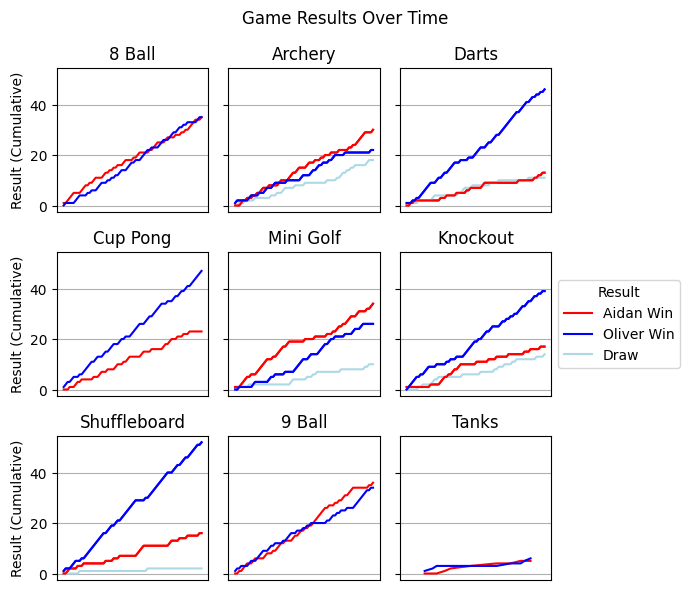

In [60]:
sns.set_palette(['red', 'blue', '#add8e6'])
hue_order = ['Aidan Win', 'Oliver Win', 'Draw']

# Get the unique games
games = ['8 Ball', 'Archery', 'Darts', 'Cup Pong', 'Mini Golf', 'Knockout', 'Shuffleboard', '9 Ball', 'Tanks']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7, 6), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through each game and create a plot
for i, game in enumerate(games):
    game_df = df[df['Game'] == game]
    
    # Create a cumulative count of wins for each player
    game_df['Aidan Win'] = (game_df['Result'] == 'Aidan Win').cumsum()
    game_df['Oliver Win'] = (game_df['Result'] == 'Oliver Win').cumsum()
    game_df['Draw'] = (game_df['Result'] == 'Draw').cumsum()
    
    # Convert the Date column to string
    game_df['Date'] = game_df['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    # Melt the dataframe for easier plotting
    melted_df = game_df.melt(id_vars=['Date'], value_vars=['Aidan Win', 'Oliver Win', 'Draw'], 
                             var_name='Player', value_name='Cumulative Wins')
    
    nodraws = [0, 3, 7, 8]

    # Create the line plot
    if i == 5:
        p = sns.lineplot(x='Date', y='Cumulative Wins', hue='Player', hue_order=hue_order, data=melted_df, markers='o', ax=axes[i], legend=True)
        sns.lineplot(x='Date', y='Cumulative Wins', hue='Player', data=melted_df[melted_df['Player'] != 'Draw'], markers='o', ax=axes[i], legend=False)
    elif i in nodraws:
        sns.lineplot(x='Date', y='Cumulative Wins', hue='Player', hue_order=hue_order, data=melted_df[melted_df['Player'] != 'Draw'], markers='o', ax=axes[i], legend=False)
    else:
        sns.lineplot(x='Date', y='Cumulative Wins', hue='Player', hue_order=hue_order, data=melted_df, markers='o', ax=axes[i], legend=False)
        sns.lineplot(x='Date', y='Cumulative Wins', hue='Player', data=melted_df[melted_df['Player'] != 'Draw'], markers='o', ax=axes[i], legend=False)
    axes[i].set_title(f'{game}')
    axes[i].set_xticks([])
    axes[i].set_xlabel('Series')
    axes[i].set_ylabel('Result (Cumulative)')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xticklabels('')
    axes[i].yaxis.grid(True)

p.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Result')

plt.suptitle('Game Results Over Time')

# Adjust layout
plt.tight_layout()
plt.savefig('2Series_Cumulative_Wins.png', dpi=600)
plt.show()

      Percent      Result Category
0   30.000000   Aidan Win   Series
1   30.000000        Draw   Series
2  100.000000  Oliver Win   Series
3   36.602452   Aidan Win     Game
4   46.234676        Draw     Game
5  100.000000  Oliver Win     Game


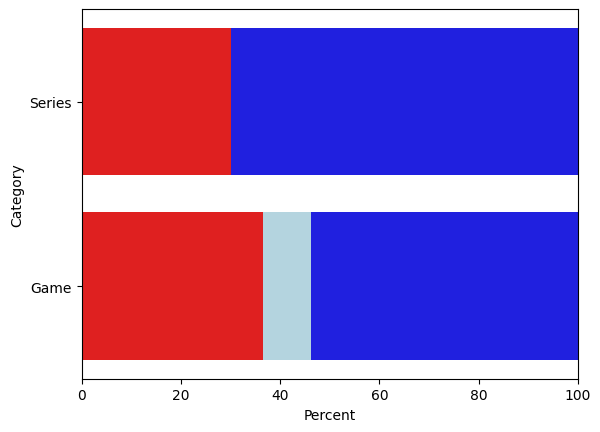

In [61]:
byseriescount = [len(aidan_wins), 0, len(oliver_wins)]
bygamecount = [len(df[df['Result'] == 'Aidan Win']), len(df[df['Result'] == 'Draw']), len(df[df['Result'] == 'Oliver Win'])]

byseriescount_sum = sum(byseriescount)
bygamecount_sum = sum(bygamecount)
byseriescount_normalized = []
bygamecount_normalized = []

for i in range(3):
    if i == 0:
        byseriescount_normalized.append(byseriescount[i] / byseriescount_sum)
        bygamecount_normalized.append(bygamecount[i] / bygamecount_sum)
    elif i == 1:
        byseriescount_normalized.append((byseriescount[i-1] + byseriescount[i]) / byseriescount_sum)
        bygamecount_normalized.append((bygamecount[i-1] + bygamecount[i]) / bygamecount_sum)
    else:
        byseriescount_normalized.append(1)
        bygamecount_normalized.append(1)

ratios = byseriescount_normalized + bygamecount_normalized
percent = []
for i in ratios:
    percent.append(i * 100)

dataframe = pd.DataFrame({'Percent': percent, 'Result': ['Aidan Win', 'Draw', 'Oliver Win'] * 2, 'Category': ['Series'] * 3 + ['Game'] * 3})
print(dataframe)

colors = ['blue', '#add8e6', 'red']
sns.set_palette(colors)
invertedresult = ['Oliver Win', 'Draw', 'Aidan Win']

for i, x in enumerate(invertedresult):
    sns.barplot(y='Category', x='Percent', data=dataframe[dataframe['Result'] == x], legend=False).set_xlim(0, 100)